# Blackjack Simulation

Credit: M. Rickard, Fin 341, Stanford Fall '19

In [8]:
import sys
import gym
import numpy as np
from collections import defaultdict
import pandas as pd

from plotutils import plot_blackjack_values, plot_policy
import matplotlib.pyplot as plt

ImportError: cannot import name 'plot_blackjack_values' from 'plotutils' (//anaconda3/lib/python3.7/site-packages/plotutils/__init__.py)

In [4]:
env = gym.make('Blackjack-v0')

In [5]:
state = env.reset()
while True:
    print("Player's Hand:", env.player)
    print("Dealer Showing", state[1])
    action = env.action_space.sample()
    print("Draw card?", "Yes" if action else "No")
    state, reward, done, info = env.step(action)
    if done:
        print('End game! Reward: ', reward)
        print("Player's Ending Hand:", env.player)
        print("Dealer's Ending Hand:", env.dealer)
        print('You won :)\n') if reward > 0 else print('You lost :(\n')
        break

Player's Hand: [7, 6]
Dealer Showing 5
Draw card? No
End game! Reward:  1.0
Player's Ending Hand: [7, 6]
Dealer's Ending Hand: [5, 7, 10]
You won :)



In [6]:
state = env.reset()
print("Player Hand:", state[0], env.player, "Dealer Showing", state[1])

Player Hand: 18 [10, 8] Dealer Showing 2


In [90]:
action = 0
state, reward, done, info = env.step(action)
print("Player Hand:", state[0], env.player, "Dealer Showing", state[1])
print("Dealer's Hand", env.dealer)
print("Reward?", reward)

Player Hand: 17 [7, 5, 1, 4] Dealer Showing 10
Dealer's Hand [10, 9]
Reward? -1.0


### MC Prediction

In [92]:
r = 0.2
def bad_policy(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [1-r, r] if state[0] > 18 else [r, 1-r]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [93]:
wins = 0
games = 10000.0
for i in range(int(games)):
    ep = bad_policy(env)
    states, actions, rewards = zip(*ep)
    if sum(rewards) > 0:
        wins += sum(rewards)

print("Win Pct:", wins/games)

Win Pct: 0.3252


- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [94]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Episode 100000/100000.

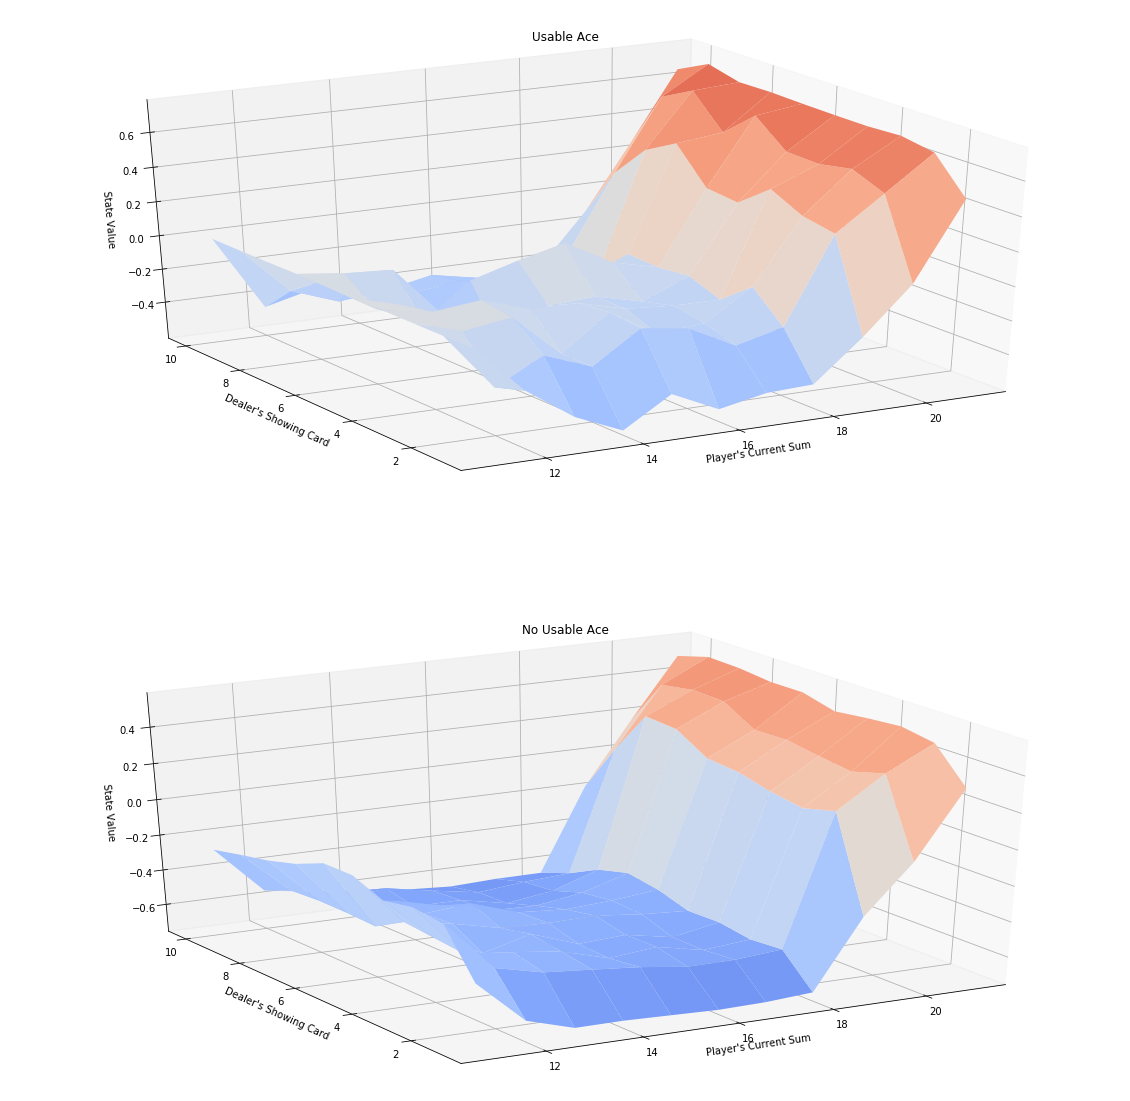

In [95]:
Q = mc_prediction_q(env, 100000, bad_policy)

V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

plot_blackjack_values(V_to_plot)

### Part 2: MC Control

- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [96]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

#### Initialize values. 
Only need Q because we aren't going to calculate the state-values simply as averages
#### Update the policy and exploration
Agent is going to learn by balancing exploration and exploitation. 
Episilon-greedy strategy:

1. Set a temporary policy to have equal probability for either action
2. Get the current best policy for the current state.
3. Get the best action based on the best policy
4. Set the probability of selecting the best action to 1 - episilon + the temporary policy

In [97]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [98]:
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

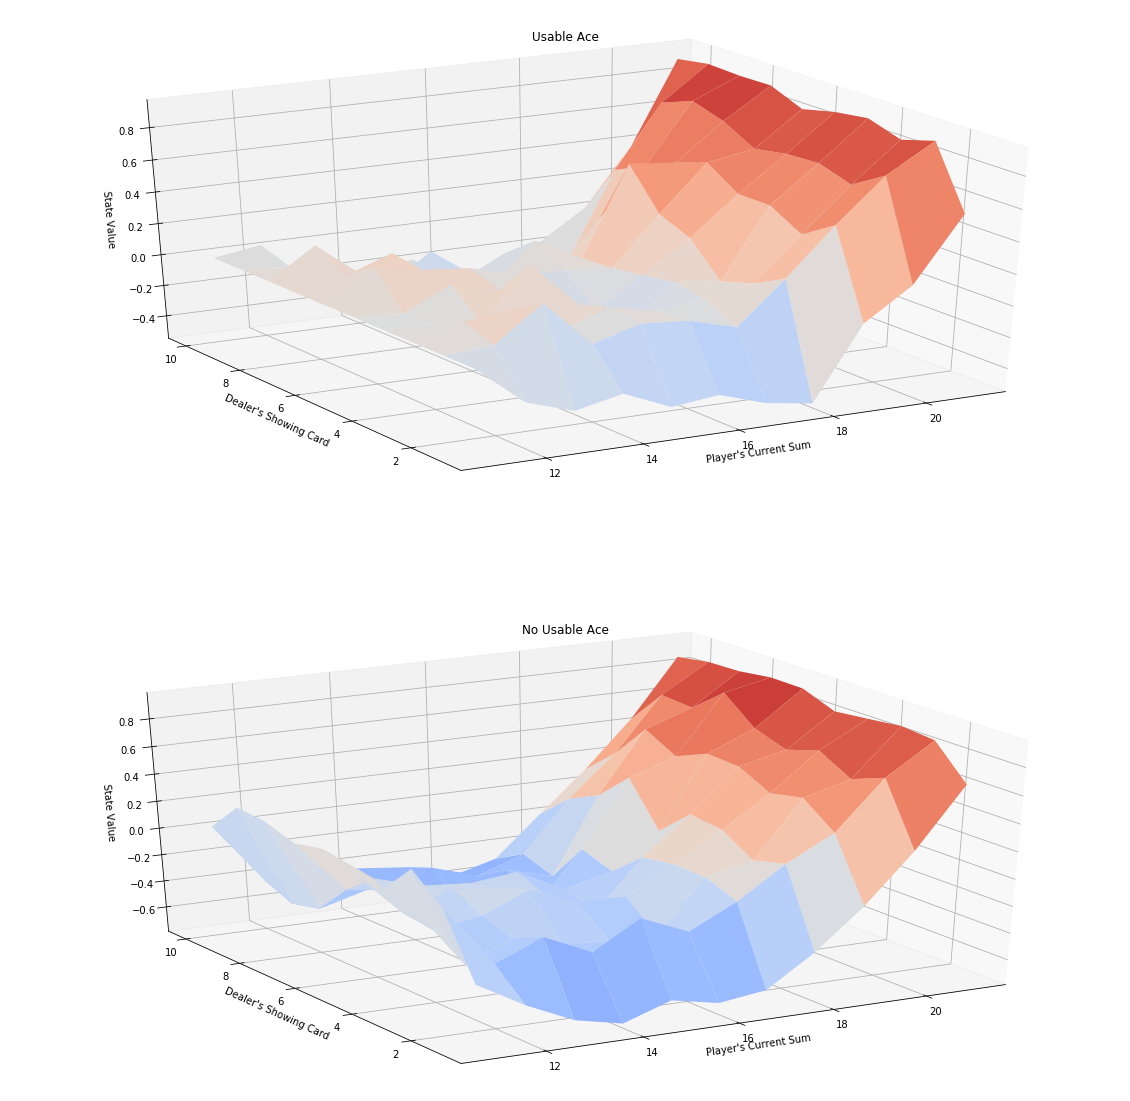

In [99]:
V = dict((k,np.max(v)) for k, v in Q.items())
plot_blackjack_values(V)

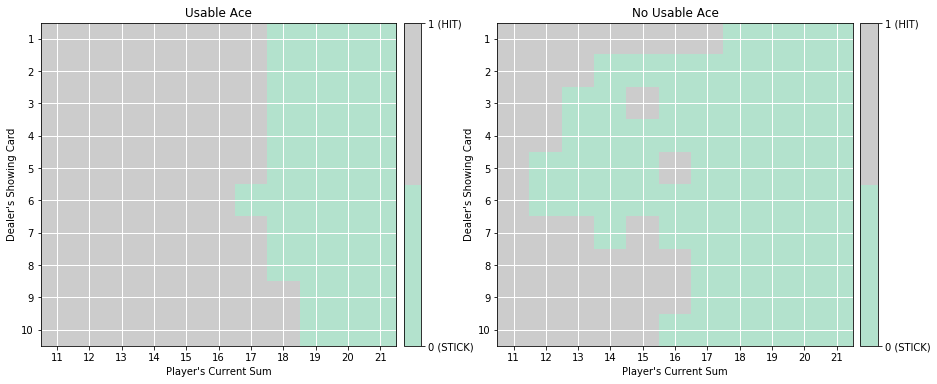

In [100]:
plot_policy(policy)

![True Optimal Policy](optimal_solution.png)